In [6]:
%%capture
!pip3 install https://storage.googleapis.com/ml-pipeline/release/latest/kfp.tar.gz --upgrade --user
!pip3 install Pillow --upgrade --user

In [2]:
import json
from string import Template

import kfp
from kfp import components
from kfp.components import func_to_container_op
import kfp.dsl as dsl

In [3]:
def convert_mnist_experiment_result(experiment_result) -> str:
    import json
    r = json.loads(experiment_result)
    args = []
    for hp in r:
        print(hp)
        args.append("%s=%s" % (hp["name"], hp["value"]))

    return " ".join(args)

@dsl.pipeline(
    name="End to end pipeline",
    description="An end to end example including hyperparameter tuning, train and inference."
)
def mnist_pipeline(
        name="mnist-{{workflow.uid}}",
        namespace="kubeflow",
        step=2000):
    # step 1: create a Katib experiment to tune hyperparameters
    objectiveConfig = {
      "type": "minimize",
      "goal": 0.001,
      "objectiveMetricName": "loss",
    }
    algorithmConfig = {"algorithmName" : "random"}
    parameters = [
      {"name": "--tf-learning-rate", "parameterType": "double", "feasibleSpace": {"min": "0.01","max": "0.03"}},
      {"name": "--tf-batch-size", "parameterType": "discrete", "feasibleSpace": {"list": ["16", "32", "64"]}},
    ]
    rawTemplate = {
      "apiVersion": "kubeflow.org/v1",
      "kind": "TFJob",
      "metadata": {
         "name": "{{.Trial}}",
         "namespace": "{{.NameSpace}}"
      },
      "spec": {
        "tfReplicaSpecs": {
          "Chief": {
            "replicas": 1,
            "restartPolicy": "OnFailure",
            "template": {
              "spec": {
                "containers": [
                {
                  "command": [
                    "sh",
                    "-c"
                  ],
                  "args": [
                    "python /opt/model.py --tf-train-steps=2000 {{- with .HyperParameters}} {{- range .}} {{.Name}}={{.Value}} {{- end}} {{- end}}"
                  ],
                  "image": "liuhougangxa/tf-estimator-mnist",
                  "name": "tensorflow"
                }
                ]
              }
            }
          },
          "Worker": {
            "replicas": 3,
            "restartPolicy": "OnFailure",
            "template": {
              "spec": {
                "containers": [
                {
                  "command": [
                    "sh",
                    "-c"
                  ],
                  "args": [ 
                    "python /opt/model.py --tf-train-steps=2000 {{- with .HyperParameters}} {{- range .}} {{.Name}}={{.Value}} {{- end}} {{- end}}"
                  ],
                  "image": "liuhougangxa/tf-estimator-mnist",
                  "name": "tensorflow"
                }
                ]
              }
            }
          }
        }
      }
    }
    
    trialTemplate = {
      "goTemplate": {
        "rawTemplate": json.dumps(rawTemplate)
      }
    }

    metricsCollectorSpec = {
      "source": {
        "fileSystemPath": {
          "path": "/tmp/tf",
          "kind": "Directory"
        }
      },
      "collector": {
        "kind": "TensorFlowEvent"
      }
    }

    katib_experiment_launcher_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/katib-launcher/component.yaml')
    op1 = katib_experiment_launcher_op(
            experiment_name=name,
            experiment_namespace=namespace,
            parallel_trial_count=3,
            max_trial_count=12,
            objective=str(objectiveConfig),
            algorithm=str(algorithmConfig),
            trial_template=str(trialTemplate),
            parameters=str(parameters),
            metrics_collector=str(metricsCollectorSpec),
            # experiment_timeout_minutes=experimentTimeoutMinutes,
            delete_finished_experiment=False)

    # step2: create a TFJob to train your model with best hyperparameter tuned by Katib
    tfjobjson_template = Template("""
{
  "apiVersion": "kubeflow.org/v1",
  "kind": "TFJob",
  "metadata": {
    "name": "$name",
    "namespace": "$namespace"
  },
  "spec": {
    "tfReplicaSpecs": {
      "Chief": {
        "replicas": 1,
        "restartPolicy": "OnFailure",
        "template": {
          "spec": {
            "volumes": [
              {
                "name": "export-model",
                "persistentVolumeClaim": {
                  "claimName": "$modelpvc"
                }
              }
            ],
            "containers": [
              {
                "command": [
                  "sh",
                  "-c"
                ],
                "args": [
                  "python /opt/model.py --tf-train-steps=$step --tf-export-dir=/mnt/export $args"
                ],
                "image": "liuhougangxa/tf-estimator-mnist",
                "name": "tensorflow",
                "volumeMounts": [
                  {
                    "mountPath": "/mnt/export",
                    "name": "export-model"
                  }
                ]
              }
            ]
          }
        }
      },
      "Worker": {
        "replicas": 3,
        "restartPolicy": "OnFailure",
        "template": {
          "spec": {
            "volumes": [
              {
                "name": "export-model",
                "persistentVolumeClaim": {
                  "claimName": "$modelpvc"
                }
              }
            ],
            "containers": [
              {
                "command": [
                  "sh",
                  "-c"
                ],
                "args": [
                  "python /opt/model.py --tf-train-steps=$step --tf-export-dir=/mnt/export $args"
                ],
                "image": "liuhougangxa/tf-estimator-mnist",
                "name": "tensorflow",
                "volumeMounts": [
                  {
                    "mountPath": "/mnt/export",
                    "name": "export-model"
                  }
                ]
              }
            ]
          }
        }
      }
    }
  }
}
""")

    convert_op = func_to_container_op(convert_mnist_experiment_result)
    op2 = convert_op(op1.output)

    modelvolop = dsl.VolumeOp(
        name="modelpvc",
        resource_name="modelpvc",
        size="1Gi",
        modes=dsl.VOLUME_MODE_RWM
    )

    tfjobjson = tfjobjson_template.substitute(
            {'args': op2.output,
             'name': name,
             'namespace': namespace,
             'step': step,
             'modelpvc': modelvolop.outputs["name"]
            })

    tfjob = json.loads(tfjobjson)

    train = dsl.ResourceOp(
        name="train",
        k8s_resource=tfjob,
        success_condition='status.replicaStatuses.Worker.succeeded==3,status.replicaStatuses.Chief.succeeded==1'
    )

    # step 3: model inferencese by KFServing Inferenceservice
    inferenceservice_template = Template("""
{
  "apiVersion": "serving.kubeflow.org/v1alpha2",
  "kind": "InferenceService",
  "metadata": {
    "name": "mnist-{{workflow.uid}}"
  },
  "spec": {
    "default": {
      "predictor": {
        "tensorflow": {
          "storageUri": "pvc://$modelpvc/"
        }
      }
    }
  }
}
""")
    inferenceservicejson = inferenceservice_template.substitute({'modelpvc': modelvolop.outputs["name"]})
    inferenceservice =  json.loads(inferenceservicejson)
    inference = dsl.ResourceOp(
      name="inference",
      k8s_resource=inferenceservice,
      success_condition='status.url').after(train)

In [ ]:
pipeline = kfp.Client().create_run_from_pipeline_func(mnist_pipeline, arguments={})

1. When the pipeline done, you can get `inferenceservice` name in the pipeline output section as below, for example in this case as the picture shows in my cluster, the `inference-name` is `mnist-49570eac-1a81-484c-8eec-081c77082696`

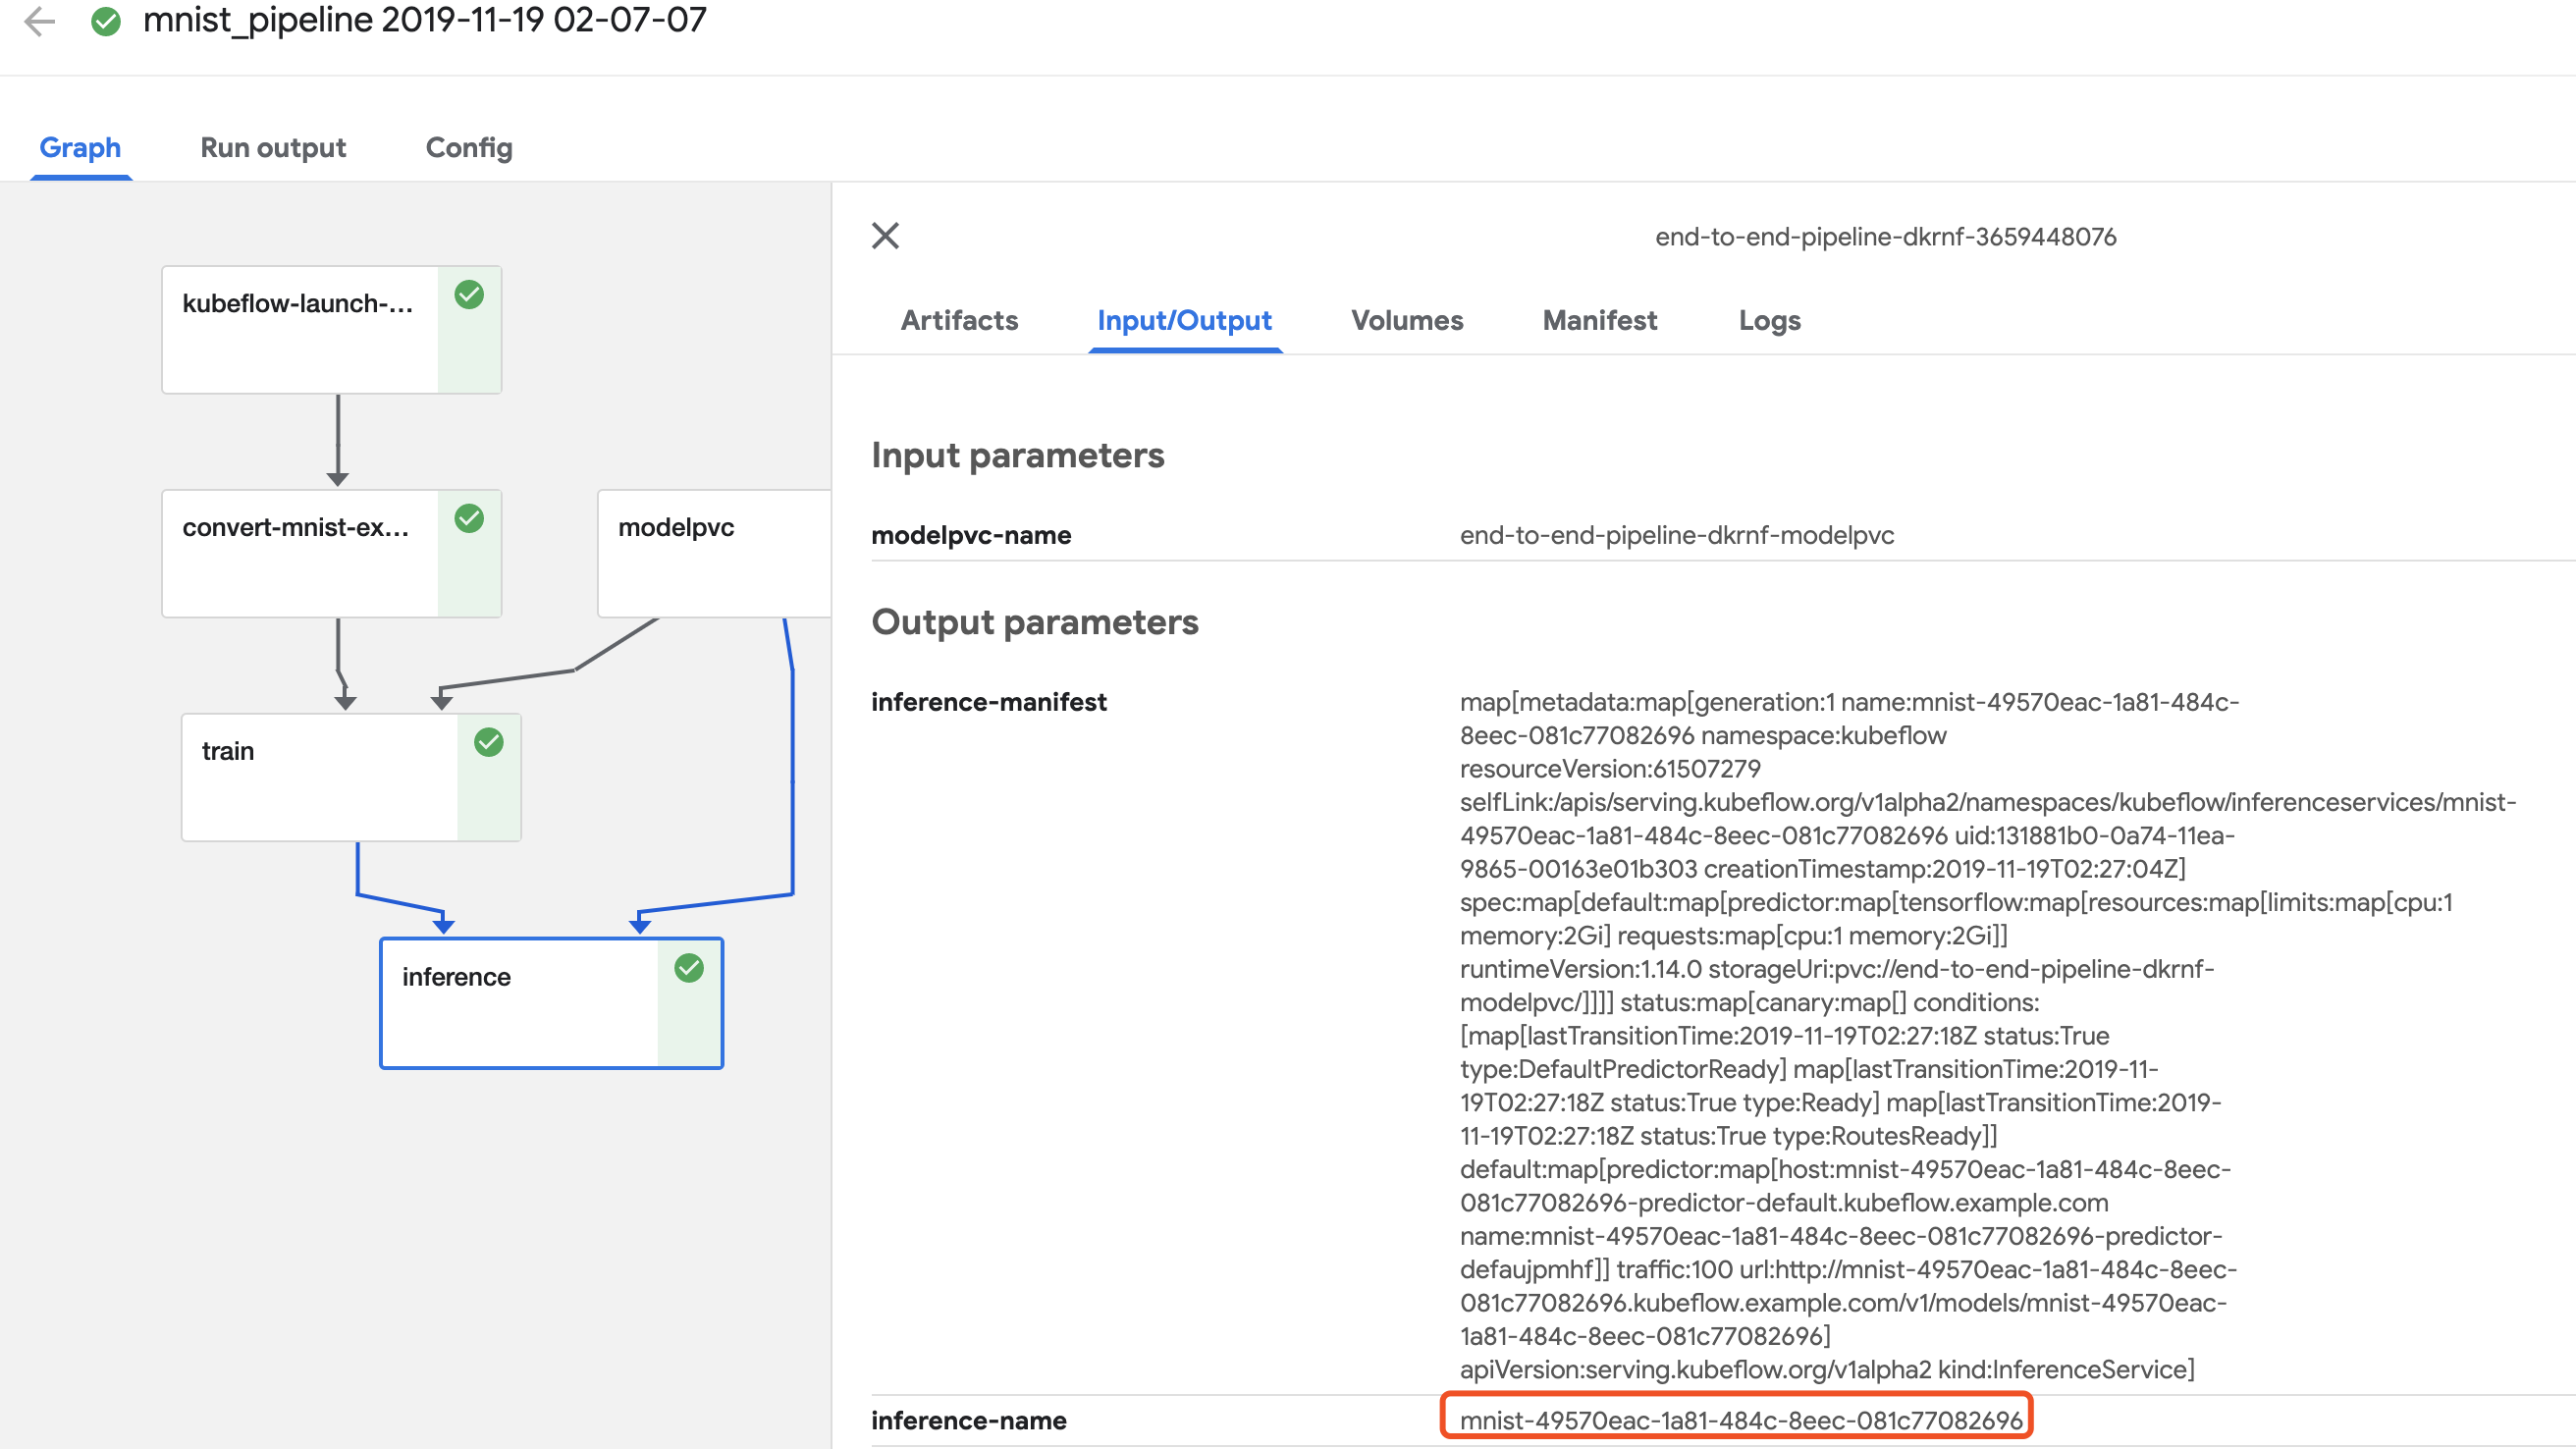

2. Download a mnist picture for inference test, such as 9.bmp from [here](https://raw.githubusercontent.com/hougangliu/pipelines/e2e-pipeline-sample/samples/contrib/e2e-mnist/9.bmp). Then upload it to the notebook.

In [10]:
import numpy as np
from PIL import Image
import requests

# Get inference_name as above step 1
inference_name = "mnist-49570eac-1a81-484c-8eec-081c77082696"
# Get cluster_ip by "kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.spec.clusterIP}'"
cluster_ip = "10.0.244.12"
# image_file is the mnist picture uploaded as above step 2
image_file = '9.bmp'
data = np.array(Image.open(image_file).convert('L').resize((28, 28))).astype(np.float).reshape(-1, 28, 28, 1)
np.set_printoptions(threshold=np.inf)       
json_request = '{{ "instances" : {} }}'.format(np.array2string(data, separator=',', formatter={'float':lambda x: "%.1f" % x}))
headers={"Host": "%s.kubeflow.example.com" % inference_name}

response = requests.post("http://%s/v1/models/%s:predict" % (cluster_ip, inference_name), data = json_request, headers = headers)
print(response.json())

{'predictions': [{'predictions': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 'classes': 9}]}
